# Logistic Regression Modelling

In [273]:
# %pip install imbalanced-learn

In [274]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [275]:
df = pd.read_excel('Cleaned_Data.xlsx')
df

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Family_Size,Total_Spent,BuyingPower
0,0,1826,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,...,4,4,6,1,1,0,54,1,198.333333,0.002338
1,1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,...,7,3,7,5,1,0,63,1,96.166667,0.001684
2,2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,...,3,2,5,2,0,0,66,3,41.833333,0.000622
3,3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,...,1,0,2,7,0,0,57,4,1.833333,0.000056
4,4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,...,3,1,2,7,1,0,35,2,15.166667,0.000706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,2235,10142,1976,PhD,Divorced,66476.0,0,1,2013-07-03,99,...,5,2,11,4,0,0,48,2,114.833333,0.001727
2230,2236,5263,1977,TwoN_Cycle,Married,31056.0,1,0,2013-01-22,99,...,1,0,3,8,0,0,47,3,9.166667,0.000295
2231,2237,22,1976,Graduation,Divorced,46310.0,1,0,2012-03-12,99,...,6,1,5,8,0,0,48,2,51.500000,0.001112
2232,2238,528,1978,Graduation,Married,65819.0,0,0,2012-11-29,99,...,5,4,10,3,0,0,46,2,230.500000,0.003502


In [276]:
selected_columns = [
    'Age',
    'Marital_Status',
    'Education',
    'Income', 
    'Kidhome', 
    'Teenhome',
    'Recency',
    # 'Dt_Customer',
    'MntFishProducts', 
    'MntMeatProducts', 
    'MntFruits', 
    'MntSweetProducts', 
    'MntWines', 
    'MntGoldProds',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth',
    # 'Family_Size',
    # 'Total_Spent',
    # 'BuyingPower',
    'Response',
    'Complain'
]
df = df[selected_columns]

In [277]:
def one_hot_encode(data, column, suffix=''):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded, lsuffix='_data', rsuffix='_encoded')
    # data = data.join(encoded)
    return data
df = one_hot_encode(df, 'Marital_Status')
df = one_hot_encode(df, 'Education')

# from sklearn.calibration import LabelEncoder


# le_Education = LabelEncoder()
# le_Marital_Status = LabelEncoder()

# df['Marital_Status'] = le_Marital_Status.fit_transform(df['Marital_Status'])
# df['Education'] = le_Education.fit_transform(df['Education'])

# df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed')
df

,Age,Income,Kidhome,Teenhome,Recency,MntFishProducts,MntMeatProducts,MntFruits,MntSweetProducts,MntWines,...,Response,Complain,Married,Single,Together,Widow,Graduation,Master,PhD,TwoN_Cycle
0,54,84835.0,0,0,0,111,379,104,189,189,...,1,0,False,False,False,False,True,False,False,False
1,63,57091.0,0,0,0,7,64,5,0,464,...,1,0,False,True,False,False,True,False,False,False
2,66,67267.0,0,1,0,15,59,11,2,134,...,0,0,True,False,False,False,True,False,False,False
3,57,32474.0,1,1,0,0,1,0,0,10,...,0,0,False,False,True,False,True,False,False,False
4,35,21474.0,1,0,0,11,24,16,0,6,...,1,0,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,48,66476.0,0,1,99,47,126,18,48,372,...,0,0,False,False,False,False,False,False,True,False
2230,47,31056.0,1,0,99,3,13,10,8,5,...,0,0,True,False,False,False,False,False,False,True
2231,48,46310.0,1,0,99,15,88,2,5,185,...,0,0,False,False,False,False,True,False,False,False
2232,46,65819.0,0,0,99,149,701,38,165,267,...,0,0,True,False,False,False,True,False,False,False


In [278]:
# sample = df[~(df['Single'] | df['Married'] | df['Together'] | df['Widow'])]
# sample

In [279]:
from scipy import stats


z_age = np.abs(stats.zscore(df['Age']))
z_income = np.abs(stats.zscore(df['Income']))
# z_buying_power = np.abs(stats.zscore(df['BuyingPower']))
threshold_z = 3


print("Original DataFrame Shape:", df.shape)
age_outlier_indices = np.where(z_age > threshold_z)[0]
income_outlier_indices = np.where(z_income > threshold_z)[0]
# income_buying_power = np.where(z_income > threshold_z)[0]

outlier_indices = np.array(list(set(age_outlier_indices) | set(income_outlier_indices)))

df = df.drop(outlier_indices)
print("DataFrame Shape after Removing Outliers:", df.shape)
# df

Original DataFrame Shape: (2234, 26)
DataFrame Shape after Removing Outliers: (2223, 26)


In [280]:
X = df.drop('Response', axis=1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

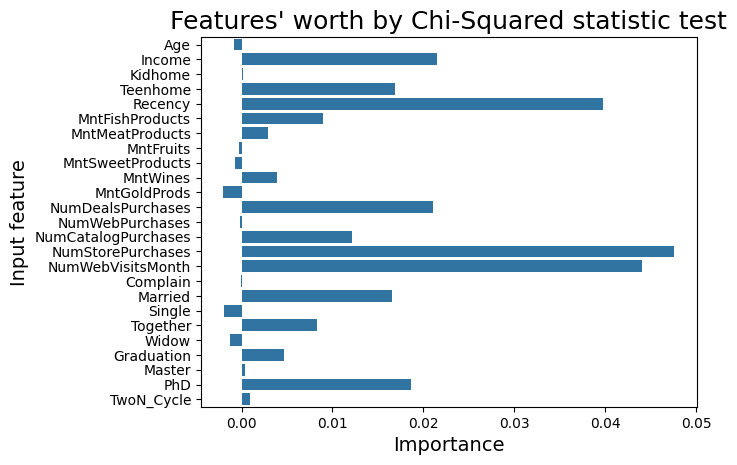

NumStorePurchases: 0.047576211894052915
NumWebVisitsMonth: 0.04407796101949019
Recency: 0.03978010994502743
Income: 0.02153923038480754
NumDealsPurchases: 0.02103948025987001
PhD: 0.018590704647676107
Teenhome: 0.016891554222888502
Married: 0.016491754122938487
NumCatalogPurchases: 0.012093953023488199
MntFishProducts: 0.008945527236381756
Together: 0.008245877061469209
Graduation: 0.004697651174412739
MntWines: 0.0038480759620189487
MntMeatProducts: 0.0028985507246376235
TwoN_Cycle: 0.0009495252373812769
Master: 0.0003998000999499762
Kidhome: 0.00014992503748124293
Complain: -9.995002498751256e-05
NumWebPurchases: -0.00014992503748127625
MntFruits: -0.00029985007496255987
MntSweetProducts: -0.0006996501749125879
Age: -0.0008495752123938493
Widow: -0.0012993503248376595
Single: -0.0018990504747626942
MntGoldProds: -0.0019990004997501734


In [281]:
# Create a ColumnTransformer for scaling
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline


# Define a ColumnTransformer for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)
    ])

# Use a pipeline to include the preprocessing step and the logistic regression model
pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fit the pipeline
pipeline.fit(X_train_resampled, y_train_resampled)

# Now, use the pipeline for permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

feature_importances = result.importances_mean
feature_indices = np.argsort(feature_importances)[::-1]

sns.barplot(y=X.columns, x=feature_importances)
plt.title("Features' worth by Chi-Squared statistic test", fontsize=18)
plt.ylabel("Input feature", fontsize=14)
plt.xlabel("Importance", fontsize=14)

plt.show()

# Print feature importance ranking
for idx in feature_indices:
    print(f"{X.columns[idx]}: {feature_importances[idx]}")

In [282]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)

clf = LogisticRegression(random_state=0)

In [283]:
# # Hyperparameter checking

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2']
}

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=1),
    'recall': make_scorer(recall_score, zero_division=1),
    'f1': make_scorer(f1_score, zero_division=1),
    'auc': make_scorer(roc_auc_score, needs_proba=True)
}

grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=5, refit='f1')

# # Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

from sklearn.model_selection import StratifiedKFold

# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)
# dahil mataas yung C value wala masyadong regularization na nagaganap therefore di nagooverfit yung model

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


In [284]:
# clf = LogisticRegression(random_state=0, C=best_params['C'], penalty=best_params['penalty'])
clf.fit(X_train_resampled, y_train_resampled)
train_preds = clf.predict(X_train_resampled)
preds = clf.predict(scaler.transform(X_test))

## Train Scores

In [285]:
acc = accuracy_score(y_train_resampled, train_preds)
prec = precision_score(y_train_resampled, train_preds)
rec = recall_score(y_train_resampled, train_preds)
f1 = f1_score(y_train_resampled, train_preds)
auc = roc_auc_score(y_train_resampled, train_preds)

In [286]:
print("Accuracy: %.4f" % acc)
print("Precision: %.4f" % prec)
print("Recall: %.4f" % rec)
print("F1: %.4f" % f1)
print("AUC: %.4f" % auc)

Accuracy: 0.7844
Precision: 0.7859
Recall: 0.7817
F1: 0.7838
AUC: 0.7844


## Test Scores

In [287]:
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc = roc_auc_score(y_test, preds)

In [288]:
print("Accuracy: %.4f" % acc)
print("Precision: %.4f" % prec)
print("Recall: %.4f" % rec)
print("F1: %.4f" % f1)
print("AUC: %.4f" % auc)

Accuracy: 0.7901
Precision: 0.3915
Recall: 0.7475
F1: 0.5139
AUC: 0.7725


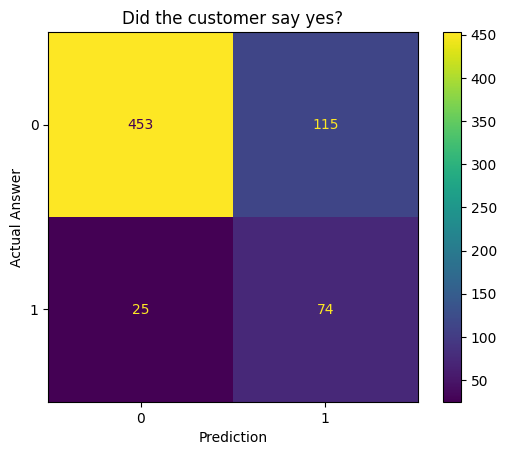

In [289]:
cm = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title('Did the customer say yes?')
plt.xlabel('Prediction')
plt.ylabel('Actual Answer')
plt.show()